In [6]:
%pylab inline
import os
import numpy as np

import matplotlib.pyplot as plt
from astropy.io import fits
from astropy.table import Table
from astropy.io import ascii

import desispec.io


Populating the interactive namespace from numpy and matplotlib


In [9]:
#directories
mocks_dir = '/global/projecta/projectdirs/desi/mocks/LGal_spectra/'
gal_inputs_dir = mocks_dir + 'gal_inputs/'
template_dir = mocks_dir + 'templates/'
desispec_dir = mocks_dir + 'spectra/'

In [10]:
def read_template(galID, SPSmodel):
    #Reads noisy template
    infile = template_dir + 'gal_spectrum_'+ str(galID) + '_BGS_template_'+SPSmodel+'.fits'
    print('Reading ' + infile)
    hdulist = fits.open(infile)
    tbdata = hdulist[1].data
    wave_template = tbdata.wave
    flux_template = tbdata.flux_nodust_nonoise* 1e-4 * 1e7 *1e17 #from W/A/m2 to 10e-17 erg/s/A/cm2
   
    hdr = hdulist[0].header
    info = {'redshift':hdr['REDSHIFT'], 'tauISM': hdr['TAUISM'], 'tauBC':hdr['tauBC'], 'cosi':hdr['COSI'], 'vd_disk':hdr['VD_DISK'], 'vd_bulge':hdr['VD_BULGE']}
    
    return wave_template, flux_template, info

In [11]:
def read_desispec(galID, SPSmodel):
    #Reads desi spectra
    specfile = desispec_dir + 'desi_out_gal_spectrum_'+ str(galID) + '_BGS_template_'+SPSmodel+'.fits'
    print('Reading ' + specfile)
    spectra = desispec.io.read_spectra(specfile)
    return spectra

In [12]:
def read_input(galID):
    #reads input star-formation and chemical enrichment histories
    infile = gal_inputs_dir + 'gal_input_' + str(galID) + '_BGS_template_FSPS_uvmiles.csv'
    gal_input = Table.read(infile, delimiter=' ')
    return gal_input

In [21]:
def plotspec(spectra, truewave=None, trueflux=None, model=None):
    plt.plot(spectra.wave['b'], spectra.flux['b'][0], 'b', alpha=0.5)
    plt.plot(spectra.wave['r'], spectra.flux['r'][0], 'r', alpha=0.5)
    plt.plot(spectra.wave['z'], spectra.flux['z'][0], 'k', alpha=0.5)
    if truewave is not None and trueflux is not None:
        plt.plot(truewave, trueflux, 'k-', label=model)

    plt.axhline(0, color='k', alpha=0.2)
        
    ymin = ymax = 0.0
    for x in ['b', 'r', 'z']:
        tmpmin, tmpmax = np.percentile(spectra.flux[x][0], [1, 99])
        ymin = min(tmpmin, ymin)
        ymax = max(tmpmax, ymax)
        
    plt.ylim(ymin, ymax)
    plt.xlim(3000,10000)
    plt.ylabel('flux [1e-17 erg/s/cm2/A]')
    plt.xlabel('wavelength [A]')

**Reading all the information and making some plots:**

Reading /global/projecta/projectdirs/desi/mocks/LGal_spectra/spectra/desi_out_gal_spectrum_10062_BGS_template_BC03_Stelib.fits
Reading /global/projecta/projectdirs/desi/mocks/LGal_spectra/templates/gal_spectrum_10062_BGS_template_BC03_Stelib.fits
Reading /global/projecta/projectdirs/desi/mocks/LGal_spectra/templates/gal_spectrum_10062_BGS_template_FSPS_uvmiles.fits


{'cosi': 0.2,
 'redshift': 0.2070965,
 'tauBC': 5.14842703878321,
 'tauISM': 1.407555954127802,
 'vd_bulge': 182.6189833763555,
 'vd_disk': 50.0}

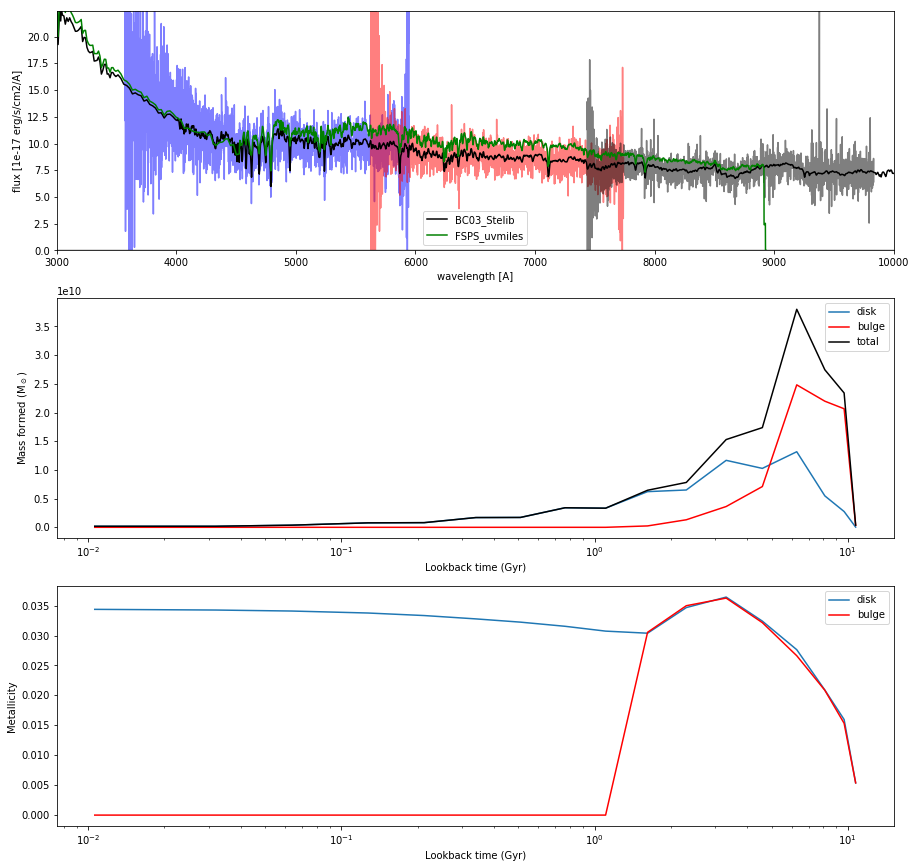

In [26]:
galID = 10062 #pick a galaxy
SPSmodel = 'BC03_Stelib'
plt.figure(figsize=(15,15))

spectra = read_desispec(galID, SPSmodel)
wave_template, flux_template, gal_info = read_template(galID, SPSmodel)
wave_template_FSPS, flux_template_FSPS, gal_info = read_template(galID, 'FSPS_uvmiles') #read same galaxy with FSPS for comparison
gal_input = read_input(galID)

plt.subplot(3,1,1)
plotspec(spectra, truewave=wave_template, trueflux=flux_template, model=SPSmodel)
plt.plot(wave_template_FSPS, flux_template_FSPS, color='green', label='FSPS_uvmiles')
plt.legend()

plt.subplot(3,1,2)
plt.semilogx(gal_input['sfh_t'], gal_input['sfh_disk'], label='disk')
plt.plot(gal_input['sfh_t'], gal_input['sfh_bulge'], color='red', label='bulge')
plt.plot(gal_input['sfh_t'], gal_input['sfh_bulge'] + gal_input['sfh_disk'], color='black', label='total')
plt.legend()
plt.ylabel('Mass formed (M$_\odot$)')
plt.xlabel('Lookback time (Gyr)')

plt.subplot(3,1,3)
plt.semilogx(gal_input['sfh_t'], gal_input['Z_disk'], label='disk')
plt.plot(gal_input['sfh_t'], gal_input['Z_bulge'], color='red', label='bulge')
plt.legend()
plt.ylabel('Metallicity')
plt.xlabel('Lookback time (Gyr)')
gal_info